# Finding Similar Songs on Spotify - Part 1: Nearest Neighbor Search

The first part of this tutorial series demonstrates the traditional way of extracting features from the audio content, training a classifier and predicting results. Because we do not have access to the raw audio content, we cannot extract features ourselves. Fortunately, Spotify is so generious to provide extracted features via their API. Those are just low-level audio features, but they are more than any other streaming music service provide - so Kudos to Spotify for this API! To download the features from the Spotify API you need to apply for a valid client ID. Please follow the steps on the Github page to apply for such an ID.


## Part 1 - Overview

1. Introduction
2. Accessing the Spotify API
3. Loading data
4. Preprocess data
5. Define the Similarity Model
6. Optimize the Model
7. Evaluate the Models


# Short Introduction to Music Similarity Retrieval

The objective of Music Similarity estimation or retrieval is to estimate the notion of similarity between two given tracks. A central part of such an approaches is the definition of a measure for similarity which is further affected by the approach taken to extract the relevant information. One approach is to analyze contextual data such as user generated listening behaviour data (e.g. play/skip-counts, user-tags, ratings, etc.). The approach followed by this tutorial is based on the music content itself and largely focuses on the notion of *acoustic similarity*. Music features are extracted from the audio content. The resulting music descriptors are high-dimensional numeric vectors and the accumulation of all feature vectors of a collection forms a vector-space. The general principle of content based similarity estimations is based on the assumption that numerical differences are an expression of perceptual dissimilarity. Different metrics such as the Manhattan (L1) or the Euclidean Distance (L2) or non-metric similarity functions such as the Kullback-Leibler divergence are used to estimate the numerical similarity of the feature vectors.

# Requirements

Please follow the instructions on the tutorial's Github page (https://github.com/slychief/tutorials/tree/master/spotify_similarity_search) to install the following dependencies to run this tutorial:

In [730]:
# visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

# numeric and scientific processing
import numpy as np
import pandas as pd

# misc
import os
import progressbar

**Spotipy**

Spotipy is a thin client library for the Spotify Web API.

https://github.com/plamere/spotipy

In [731]:
import spotipy
import spotipy.util as util

Update the following two variables according the credentials you received from Spotify

In [732]:
os.environ["SPOTIPY_CLIENT_ID"]     = "8a7fffc37b6c44e6b7bc344c3295034c"
os.environ["SPOTIPY_CLIENT_SECRET"] = "f19dd914ba58408c9407dd6479b23812"

If you get the following message:

    User authentication requires interaction with your
    web browser. Once you enter your credentials and
    give authorization, you will be redirected to
    a url.  Paste that url you were directed to to
    complete the authorization.

    Opened https://accounts.spotify.com/authorize?scope=playlist-modify-public&redirect_uri=ht...
    

You need to authenticate your browser session. Follow the link and log in to Spotify. After login, you will be redirected to http://localhost/?code=... Copy the entire URL and paste it to the prompted textbox.

In [733]:
token = util.prompt_for_user_token("slychief", 
                                   "playlist-modify-public", 
                                   redirect_uri="http://localhost/")

sp = spotipy.Spotify(auth=token)

# Loading Data

Before we can train our models we first have to get some data.

## Download Echonest Features from Spotify

We use spotipy to access the Spotify API and to download metadata and audio features of Spotify tracks. The following list provides a selection of Spotify playlists of various music genres.

In [734]:
playlists = [
    
     {"name": "clubbeats",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DXbX3zSzB4MO0"},
     {"name": "softpop",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DWTwnEm1IYyoj"},
     {"name": "electropop",   "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4uPi2roRUwU"},
     {"name": "rockclassics", "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXRqgorJj26U"},
     {"name": "rockhymns",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX4vth7idTQch"},
     {"name": "soft_rock",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DX6xOPeSOGone"},
     {"name": "metalcore",    "uri": "spotify:user:spotify:playlist:37i9dQZF1DWXIcbzpLauPS"}, 
     {"name": "metal",        "uri": "spotify:user:spotify:playlist:37i9dQZF1DWWOaP4H0w5b0"},
     {"name": "classic_metal","uri": "spotify:user:spotify:playlist:37i9dQZF1DX2LTcinqsO68"},
     {"name": "grunge",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DX11ghcIxjcjE"},
     {"name": "hiphop",       "uri": "spotify:user:spotify:playlist:37i9dQZF1DWVdgXTbYm2r0"},
     {"name": "poppunk",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXa9wYJr1oMFq"},
     {"name": "classic",      "uri": "spotify:user:spotify:playlist:37i9dQZF1DXcN1fAVSf7CR"}
    
]

### Get Playlist meta-data

Insted of writing one big loop to download the data, I decided to split it into separate more comprehensible steps.

The Spotify API does not return infinite elements, but requires batch processing. The largest batch size is 100 items such as tracks, artists or albums. As a first step we get relevant meta-data for the supplied playlists. Especially the *num_track* property is conveniant for the further processing.

In [735]:
def get_playlist_metadata(spotify_client, playlists):

    for playlist in playlists:

        # get user and playlist_id from uri
        (_,_,user,_,playlist_id) = playlist["uri"].split(":")

        # retrieve playlist metadat from Spotify
        playlist_metadata = spotify_client.user_playlist(user        = user,
                                                         playlist_id = playlist_id)

        # extract relevant information
        playlist["user"]        = user
        playlist["playlist_id"] = playlist_id
        playlist["num_tracks"]  = playlist_metadata["tracks"]["total"]

        # initialize fields for further processing
        playlist["track_ids"]   = []
        
    return playlists

Run the function to get the data

In [736]:
playlists = get_playlist_metadata(sp, playlists)

**Size of our dataset**

Now we can already estimate the approximate size of our data-set. The set might contain duplicate tracks from overlapping playlists. Those are removed later on.

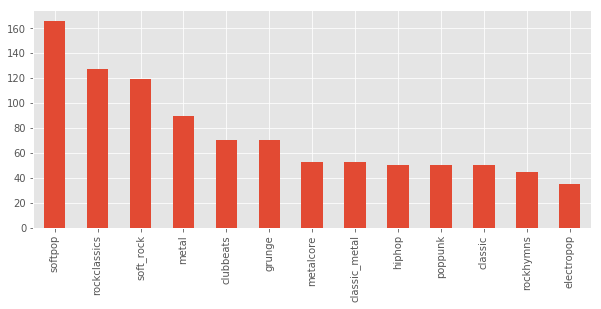

In [767]:
playlist_sizes = pd.DataFrame(data  = [playlist["num_tracks"] for playlist in playlists],
                              index = [playlist["name"] for playlist in playlists])

playlist_sizes.sort_values(0,ascending=False).plot(kind='bar', figsize=(10,4), legend=False);

In [764]:
# Total number of tracks (including duplicates - will be removed later on)
int(playlist_sizes.sum())

978

### Get track-ids of all playlist entries

To download meta- and feature-data for tracks, we need to fetch the playlist entries.

In [718]:
def get_track_ids(sp, playlists):

    # max Spotify batch size
    batch_size = 100

    # retrieve tracks for each playlist
    for playlist in playlists:

        # batch processing
        for offset in np.arange(0, playlist["num_tracks"], batch_size):

            limit = np.min([batch_size, playlist["num_tracks"] - offset])

            playlist_entries = sp.user_playlist_tracks(user        = playlist["user"],
                                                       playlist_id = playlist["playlist_id"], 
                                                       limit       = limit, 
                                                       offset      = offset,
                                                       fields      = ["items"])

            playlist["track_ids"].extend([entry["track"]["id"] for entry in playlist_entries["items"]])
            
    return playlists

Run the function to get the data

In [719]:
playlists = get_track_ids(sp, playlists)

### Fetch data and features from Spotify

Now it's time to download the dat for our tracks.

The features provided by the Spotify API were extracted using the *Echonest Analyzer*. This is a music audio analysis tool developed by the music analysis company the Echonest which was aquired by Spotify in 2014. Music metadata returned by the Analyzer includes artist information (name, user applied tags including weights and term frequencies, a list of similar artists), album information (name, year) and song information (title). Additionally a set of identifiers is provided that can be used to access complimentary metadata repositories (e.g. musicbrainz\footnote{http://musicbrainz.org}, playme\footnote{http://www.playme.com},7digital).

#### Caching with joblib

We will use caching to locally store retrieved data. This is on the one hand a requirement of the API and on the other it speeds up processing when we reload the notebook. *joblib* is a convenient library which simplifies caching.

*Update the cachdir to an appropriate path in the following cell*

In [82]:
from joblib import Memory

memory = Memory(cachedir='/home/schindler/tmp/spotify/', verbose=0)

The following method retrieves meta-data, sequential features such as *MFCCs* and *Chroma*, and track-level features such as *Dancability*. The *@memory.cache* annotation tells *joblib* to persist all return values for the supplied parameters.

In [83]:
@memory.cache
def get_spotify_data(track_id):
    
    # meta-data
    track_metadata      = sp.track(track_id)
    album_metadata      = sp.album(track_metadata["album"]["id"])
    artist_metadata     = sp.artist(track_metadata["artists"][0]["id"])
    
    # feature-data
    sequential_features = sp.audio_analysis(track_id)
    trackbased_features = sp.audio_features([track_id])
    
    return track_metadata, album_metadata, artist_metadata, sequential_features, trackbased_features

**Retrieving data for all tracks**

The following loop downloads meta- and feature-data for all tracks. The *processed_track_ids* list is used to avoid duplicated entries. Be aware that downloading a lot of tracks could take some time. Processing 1.000 tracks may take about 15 to 30 minutes.

In [720]:
def download_track_data(sp, playlists):

    pbar = progressbar.ProgressBar(max_value=num_tracks_total)
    pbar.start()

    raw_track_data      = []
    processed_track_ids = []

    for playlist in playlists:

        for track_id in playlist["track_ids"]:

            try:
                # avoid duplicates in the data-set
                if track_id not in processed_track_ids:

                    # retrieve data from Spotify
                    spotify_data = get_spotify_data(track_id)

                    raw_track_data.append([playlist["name"], spotify_data])
                    processed_track_ids.append(track_id)

            except Exception as e:
                print e

            pbar.update(len(raw_track_data))
            
    return raw_track_data

Run the function to get the data

In [721]:
raw_track_data = download_track_data(sp, playlists)

 62% (606 of 970) |#################################################################################################################                                                                     | Elapsed Time: 0:00:25 ETA: 0:00:20

Unterminated string starting at: line 1 column 65530 (char 65529)


 97% (942 of 970) |################################################################################################################################################################################      | Elapsed Time: 0:00:40 ETA: 0:00:01

# Aggregate data

Currently we only have a list of raw data-objects retrieved from the Spotify API. We need to transform this information to a more structured format.

## Aggregate Meta-data

First we aggregate the meta-data. All relevant information is stored in a dataframe.

In [722]:
def aggregate_metadata(raw_track_data):

    metadata = []

    for playlist_name, spotify_data in raw_track_data:

        track_metadata, album_metadata, artist_metadata, _, _ = spotify_data

        # get year of album release
        release_date = album_metadata["release_date"]

        if album_metadata["release_date_precision"] != "year":
            release_date = release_date.split("-")[0]

        # assamble metadata
        metadata.append([track_metadata["id"],
                         artist_metadata["name"], 
                         track_metadata["name"], 
                         album_metadata["name"],
                         album_metadata["label"],
                         track_metadata["duration_ms"],
                         track_metadata["popularity"],
                         release_date,
                         artist_metadata["genres"], 
                         playlist_name])

    metadata = pd.DataFrame(metadata, columns=["track_id", "artist_name", "title", "album_name", 
                                               "label", "duration", "popularity",  "year",  "genres", 
                                               "playlist"])
    
    return metadata

In [723]:
metadata = aggregate_metadata(raw_track_data)

Here an example of the aggregated meta-data:

In [724]:
metadata.sort_values("popularity", ascending=False).head()

,track_id,artist_name,title,album_name,label,duration,popularity,year,genres,playlist
800,2eMwDehkIC1j68U6FA3Eiq,Lil Uzi Vert,XO TOUR Llif3,XO TOUR Llif3,Generation Now/Atlantic,182706,96,2017,"[dwn trap, rap]",hiphop
805,5eqK0tbzUPo2SoeZsov04s,21 Savage,Bank Account,Issa Album,"Slaughter Gang, LLC/Epic Records",220306,96,2017,"[dwn trap, rap, trap music]",hiphop
100,7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran,Shape of You,÷ (Deluxe),Atlantic Records UK,233712,96,2017,[pop],softpop
96,1wjzFQodRWrPcQ0AnYnvQ9,Lauv,I Like Me Better,I Like Me Better,Lauv,197436,96,2017,"[indie poptimism, pop, post-teen pop, tropical...",softpop
248,4q8PHoRsPUB52LFylX8Ulz,Axwell /\ Ingrosso,More Than You Know,More Than You Know,Digital Distribution Trinidad and Tobago,203000,96,2017,"[big room, edm, electro house, pop, tropical h...",electropop


## Aggregate Feature Data


Further information provided by the Spotify API is based on audio signal analysis. Two major sets of audio features are provided describing timbre and pitch information of the corresponding music track. The features are extracted using onset detection to segment the audio based on music events. These *Segments* are described as sound entities that are relative uniform in timbre and harmony and are the basis for further feature extraction. For each *Segment* the following features are derived from musical audio signals:

* **Segments Timbre** are casually described as MFCC-like features. A 12 dimensional vector with unbounded values centered around 0 representing a high level abstraction of the spectral surface.
* **Segments Pitches** are casually described as Chroma-like features. A normalized 12 dimensional vector ranging from 0 to 1 corresponding to the 12 pitch classes C, C#, to B.
* **Segments Loudness Max** represents the peak loudness value within each segment.
* **Segments Loudness Max Time** describes the offset within the segment of the point of maximum loudness.
* **Segments Start** provide start time information of each segment/onset.

Additionally a set of high-level features provided on a global track-level:

* **Tempo** measured in beats per minute
* **Time Signature** three or four quater stroke
* **Danceability** a value between 0 and 1 measuring of how danceable this song is 
* **Energy** a value between 0 and 1 measuring the perceived energy of a song
* **acousticness** does the track only use acoustic instruments?
* **danceability** can you dance to this track?
* **instrumentalnes** is there somebody singing?
* **liveness** live or studio version?
* **speechiness** rap music or singing?
* **valence** aggressive or calm?

I performed a detailed evaluation of the Echonest Feature-sets and how to effectively aggregate the provided information for Music Information Retrieval Experiments on the Million Song Dataset. The results are published in the following article:

* *Alexander Schindler and Andreas Rauber. [Capturing the temporal domain in echonest features for improved classification effectiveness](http://www.ifs.tuwien.ac.at/%7Eschindler/pubs/AMR2012.pdf). In Adaptive Multimedia Retrieval, Lecture Notes in Computer Science, Copenhagen, Denmark, October 24-25 2012. Springer.*

### Single Vector Representation

The simlarity retrieval approach presented in this tutorial is based on a vector-space model where each track is represented of a single fixed-length feature vector. The segment-based features provided by the Spotify API are lists of feature vectors of varying lengths. Thus, these features need to be aggregated into a single feature vector. The following function describes a simple approach to do so:

In [694]:
def aggregate_features(seq_data, track_data, metadata, with_year=False, with_popularity=False):

    calc_statistical_moments = lambda x: np.concatenate([x.mean(axis=0), x.std(axis=0)])
    
    # sequential data
    segments = seq_data["segments"]
    sl       = len(segments)
    
    # MFCCs - 24 dimensions
    mfcc              = np.array([s["timbre"] for s in segments])
    mfcc              = calc_statistical_moments(mfcc)
    
    # Chroma / pitch classes - 24 dimensions
    chroma            = np.array([s["pitches"] for s in segments])
    chroma            = calc_statistical_moments(chroma)
    
    # maximum loudness values per segment - 2 dimensions
    loudness_max      = np.array([s["loudness_max"] for s in segments]).reshape((sl,1))
    loudness_max      = calc_statistical_moments(loudness_max)
    
    # offset of max loudness value within segment - 2 dimensions
    loudness_start    = np.array([s["loudness_start"] for s in segments]).reshape((sl,1))
    loudness_start    = calc_statistical_moments(loudness_start)
    
    # length of max loudness values within segment - 2 dimensions
    loudness_max_time = np.array([s["loudness_max_time"] for s in segments]).reshape((sl,1))
    loudness_max_time = calc_statistical_moments(loudness_max_time)
    
    # length of segment - 2 dimensions
    duration          = np.array([s["duration"] for s in segments]).reshape((sl,1))
    duration          = calc_statistical_moments(duration)
    
    # confidence of segment boundary detection - 2 dimensions
    confidence        = np.array([s["confidence"] for s in segments]).reshape((sl,1))
    confidence        = calc_statistical_moments(confidence)
    
    # concatenate sequential features
    sequential_features = np.concatenate([mfcc, chroma, loudness_max, loudness_start, 
                                          loudness_max_time, duration, confidence], axis=0)
    
    # track-based data
    track_features = [track_data[0]["acousticness"],     # acoustic or not?
                      track_data[0]["danceability"],     # danceable?
                      track_data[0]["energy"],           # energetic or calm?
                      track_data[0]["instrumentalness"], # is somebody singing?
                      track_data[0]["liveness"],         # live or studio?
                      track_data[0]["speechiness"],      # rap or singing?
                      track_data[0]["tempo"],            # slow or fast?
                      track_data[0]["time_signature"],   # 3/4, 4/4, 6/8, etc.
                      track_data[0]["valence"]]          # happy or sad?
    
    if with_year:
        track_features.append(int(metadata["year"]))
        
    if with_popularity:
        track_features.append(int(metadata["popularity"]))
        
    
    return np.concatenate([sequential_features, track_features], axis=0)

Afgregate all features of the downloaded data

In [725]:
def aggregate_featuredata(raw_track_data):

    feature_data = []

    for i, (_, spotify_data) in enumerate(raw_track_data):

        _, _, _, f_sequential, f_trackbased = spotify_data

        feature_vec = aggregate_features(f_sequential, 
                                         f_trackbased, 
                                         metadata.iloc[i], 
                                         with_year       = True, 
                                         with_popularity = True)    

        feature_data.append(feature_vec)

    return np.asarray(feature_data)

In [726]:
feature_data = aggregate_featuredata(raw_track_data)

print "feature_data.shape:", feature_data.shape

feature_data.shape: (944, 69)


### Normalize feature data

The feature vectors are composed of differnt feature-sets. All of them with different value ranges. While features such as Acousticness and Danceability are scaled between 0 and 1, the BPM values of the tempo feature ranges around 120 or higher. We apply Standard Score or Zero Mean and Unit Variance normalization to uniformly scale the value ranges of the features.

$$
z = {x- \mu \over \sigma}
$$

In [696]:
# standardize sequential_features
feature_data -= feature_data.mean(axis=0)
feature_data /= feature_data.std(axis=0)

# Calculate Similarities

This section describes the fundamentals of the content-based audio similarity search approach followed in this tutorial. Audio features are descriptive numbers calculated from the audio spectrum of a track. A good example is the Spectral Centroid, which can be interpreted as the center of gravity of an audio recording. It describes the average frequency weighted by its intensity and distinguishes brighter from darker sounds. Such features are usually calculated for several intervals of a track and finally aggregated into a single vector representation. The latter step, which is a requirement for many machine/statistical learning tasks, is accomplished by calculating statistical measures such as mean, standard deviation, etc.

In the following example, the Spectral Centroids of 10 different tracks are provided using their mean and standard deviation aggregations. Thus, the Spectral Centroid feature(-set) is represented by a two-dimensional feature vector such as the following example:

    ID   Mean                  Standard Deviation
    0    1517.5993814237531    291.1855836731788

In this example the center frequency is 1518 Hz and it deviates by 291 Hz. These numbers already describe the audio content and can be used to find similar tracks. The common approach to calcualte music similarity from audio content is based on vector difference. The assumption is, that similar audio feature-values correspond with similar audio content. Thus, feature vectors with smaller vector differences correspond to more similar tracks. The following data represents the extracted Spectral Centroids of our 10-tracks collection:


    ID   Mean                  Standard Deviation
    0    1517.5993814237531    291.1855836731788
    1    1659.1988993873124    327.64811981777865
    2    1507.4617047141264    340.8830079395701
    3    1597.6019371942953    507.1007933367403
    4    1498.8531206911534    288.3780838480238
    5    535.5910732230583     89.90893994909047
    6    2261.4032345595674    353.5971736260454
    7    2331.881852844861     406.33517225264194
    8    1868.690426450363     342.7489751514078
    9    2204.6324484864085    328.94334883095553

The tracks have unique identifiers and we are using the track with ID 5 to search for similar items. This step requires a similarity metric, which defines how the vector distance has to be calculated as a single numeric value. The most common choices are the Manhattan (L1) and Euclidean (L2) distance measures. The Euclidean Distance is the square root of the sum of squared differences of two vectors.
To calculate the Euclidean Distance between track 5 and track 0:

    ID   Mean                  Standard Deviation
    0    1517.5993814237531    291.1855836731788
    5    535.5910732230583     89.90893994909047

we first compute the difference between the values of each vectors

    982.008308           201.276644

square them to get the absolute magnitude:

    964340.317375        40512.287309

and take the sum of these values:

    1004852.6046840245

Per definition the square root has to be calculated from the sum, but this step is normally skipped because it does not alter the ranking and is processing intensive. By calculating the distance for all items in the collection, we retrieve a list of distance values where the smaller distances correspond to more similar audio content and the higher values should sound more dissimilar.

    ID   Distance
    0    1004852.6046840245
    1    1319014.4646621975
    2    1007520.5071585375
    3    1301916.1177259558
    4    967263.7731724023
    5    0.0
    6    3047959.100796666
    7    3326786.1254441254
    8    1841081.968976167
    9    2842836.5609704787

To retrieve a ranked list of similar sounding tracks, the list of vector distances has to be ordered ascendingly.

    ID   Distance
    5    0.0
    4    967263.7731724023
    0    1004852.6046840245
    2    1007520.5071585375
    3    1301916.1177259558
    1    1319014.4646621975
    8    1841081.968976167
    9    2842836.5609704787
    6    3047959.100796666
    7    3326786.1254441254

This so called vector space model is predominant in content based multimedia retrieval. The most crucial and problematic part is feature crafting, meaning that in the case in which the extracted numbers do not describe the audio well enough, the vector based similarity will also fail to provide results that are perceived as similar.
The described approach requires the availability of all feature vectors of all items of a collection. Thus, the feature vectors must be stored. No matter which retrieval approach (pre-calculated / indexed / on demand) will be chosen, all features will be required at a certain time. Given that the feature extraction is an computationally expensive task (in terms of processing resources and total time), the extracted features are stored and made accessible using a common data format.


### Euclidean Distance

In the final part of this tutorial we wil use the Euclidean Distance to calculate similarities between tracks. As mentioned above, the Euclidean Distance is a metric to calculate the distance between two vectors and thus is a function of dissimilarity. This means, vectors with smaller distance values are more similar than those with higher distances.

$$
d(p,q) = \sqrt{\sum_{i=1}^n (q_i-p_i)^2}
$$


In [768]:
def eucledian_distance(feature_space, query_vector):
    
    return np.sqrt(np.sum((feature_space - query_vector)**2, axis=1))

For the rest of the tutorial we will use this song to demonstrate the results of the approach:

In [786]:
query_track_idx = 268

metadata.loc[[query_track_idx]]

,track_id,artist_name,title,album_name,label,duration,popularity,year,genres,playlist
268,1RJeiAIwR9pZBgJA8ndZLL,The Rolling Stones,"Paint It, Black - Mono / Remastered",The Rolling Stones In Mono (Remastered 2016),"ABKCO Music & Records, Inc.",204480,60,1966,"[album rock, british invasion, classic rock, f...",rockclassics


The following lines of code implement the approach described above. First, the distances between the query vector and all other vectors of the collection are calculated. Then the distances are sorted ascnedingly to get the simlar tracks. Because the metric distance of identical vectors is 0, the top-most entry of the sorted list is always the query track.

In [782]:
# calculate the distance between the query-vector and all others
dist = eucledian_distance(feature_data, feature_data[query_track_idx])

# sort the distances ascendingly - use sorted index
sorted_idx = np.argsort(dist)

# display top-10 results (first track = query track)
display_cols = ["artist_name", "title", "album_name", "year", "playlist"]

metadata.loc[sorted_idx[:11], display_cols]

,artist_name,title,album_name,year,playlist
268,The Rolling Stones,"Paint It, Black - Mono / Remastered",The Rolling Stones In Mono (Remastered 2016),1966,rockclassics
687,Judas Priest,Breaking the Law,British Steel,1980,classic_metal
386,Bruce Springsteen,Born to Run,Born To Run,1975,rockclassics
338,The Doors,Love Her Madly,L.A. Woman,1971,rockclassics
285,Black Sabbath,Iron Man - Remastered Version,Paranoid (Remastered Edition),1970,rockclassics
302,The Rolling Stones,(I Can't Get No) Satisfaction - Mono Version /...,Out Of Our Heads (Remastered),1965,rockclassics
696,Iron Maiden,Run to the Hills - 1998 Remastered Version,The Number Of The Beast (1998 Remastered Edition),1982,classic_metal
310,Jimi Hendrix,Hey Joe,Are You Experienced,1967,rockclassics
434,The Rolling Stones,(I Can't Get No) Satisfaction - Mono Version /...,Out Of Our Heads (Remastered),1965,rockhymns
738,Stone Temple Pilots,Plush,Core,1992,grunge


### Scaled Eucledian Distance

The approach taken to combine the different feature-sets is refered to as early fusion. The problem with the approach described in the previous step is, that larger feature-sets dominate the calculated distance values. The aggregated MFCC and Chroma features have 24 dimensions each. Together they have more dimensions as the remaining features which are mostly single dimensional features. Thus, the distances are unequally dominated by the two feature sets.

To avoid such a bias, we scale the feature-space such that feature-sets and single-value features have euqal the same weights and thus euqal influence on the resulting distance.

In [787]:
# feature-set lengths and order
featureset_lengths = [24, # mfcc
                      24, # chroma
                      2,  # loudness_max
                      2,  # loudness_start
                      2,  # loudness_max_time
                      2,  # sequence length
                      2,  # confidence
                      1,  # acousticness
                      1,  # danceability
                      1,  # energy
                      1,  # instrumentalness
                      1,  # liveness
                      1,  # speechiness
                      1,  # tempo
                      1,  # time_signature
                      1,  # valence
                      1,  # year
                      1]  # popularity

In [788]:
def scaled_eucledian_distance(feature_space, query_vector):
    
    distances = (feature_space - query_vector)**2
    
    # feature_start_idx
    start_idx = 0 
    
    # normalize distances
    for sequence_length in featureset_lengths:
        
        # feature_stop_idx
        stop_idx                         = start_idx + sequence_length
        distances[:,start_idx:stop_idx] /= distances[:,start_idx:stop_idx].sum(axis=1).max()
        start_idx                        = stop_idx
    
    return np.sqrt(np.sum(distances, axis=1))

Example result

In [789]:
dist = scaled_eucledian_distance(feature_data, feature_data[query_track_idx])

metadata.loc[np.argsort(dist)[:11], display_cols]

,artist_name,title,album_name,year,playlist
268,The Rolling Stones,"Paint It, Black - Mono / Remastered",The Rolling Stones In Mono (Remastered 2016),1966,rockclassics
360,Big Brother & The Holding Company,Piece of My Heart,Cheap Thrills,1968,rockclassics
726,Judas Priest,Living After Midnight,British Steel,1980,classic_metal
319,Rush,Tom Sawyer,Moving Pictures (2011 Remaster),1981,rockclassics
709,AC/DC,You Shook Me All Night Long,Back In Black,1980,classic_metal
388,Mountain,Mississippi Queen,Climbing!,1970,rockclassics
384,Def Leppard,Pour Some Sugar On Me (2012),Pour Some Sugar On Me (2012),1987,rockclassics
296,Heart,Barracuda,Little Queen,1977,rockclassics
346,Kansas,Carry on Wayward Son,Leftoverture,1976,rockclassics
348,Led Zeppelin,D'yer Mak'er,Houses Of The Holy (Deluxe Edition),1973,rockclassics


### Feature Weighting

As explained above, the vanilla Eucliden Distance in an early fusion approach is dominated by large feature-sets. Through scaling the feature-space we achieved equal influence for all feature-sets and features. Now, equal influence is not always the best choice fo music similarity. For example, the year and popularity feature we included into our feature vector are not an intrinsic music property. We just added them to cluster recordings of the same epoch together. Currently this feature has the same impact on the estimated similarity as timbre, rhythm and harmonics. When using many features it is commonly a good choice to apply different weights to them. Estimating these weights is generally achieved empirically.

In [790]:
# feature-set lengths and order
featureset_weights = [1.55,  # mfcc
                      0.6,  # chroma
                      0.8,  # loudness_max
                      0.5,  # loudness_start
                      0.5,  # loudness_max_time
                      2.5,  # sequence length
                      0.5,  # confidence
                      0.5,  # acousticness
                      0.5,  # danceability
                      1.5,  # energy
                      0.0,  # instrumentalness
                      0.0,  # liveness
                      0.1,  # speechiness
                      0.1,  # tempo
                      0.9,  # time_signature
                      0.1,  # valence
                      5.5,  # year
                      0.4]  # popularity

In [791]:
def weighted_eucledian_distance(feature_space, query_vector, featureset_weights):
    
    distances = (feature_space - query_vector)**2
    
    # feature_start_idx
    start_idx = 0 
    
    # normalize distances
    for sequence_length, weight in zip(featureset_lengths, featureset_weights):

        # feature_stop_idx
        stop_idx                         = start_idx + sequence_length
        distances[:,start_idx:stop_idx] /= distances[:,start_idx:stop_idx].sum(axis=1).max()
        distances[:,start_idx:stop_idx] *= weight
        start_idx                        = stop_idx

    return np.sqrt(np.sum(distances, axis=1))

Example result:

In [792]:
dist = weighted_eucledian_distance(feature_data, feature_data[query_track_idx], featureset_weights)

metadata.loc[np.argsort(dist)[:11], display_cols]

,artist_name,title,album_name,year,playlist
268,The Rolling Stones,"Paint It, Black - Mono / Remastered",The Rolling Stones In Mono (Remastered 2016),1966,rockclassics
360,Big Brother & The Holding Company,Piece of My Heart,Cheap Thrills,1968,rockclassics
385,Jimi Hendrix,Purple Haze,Are You Experienced,1967,rockclassics
267,Bob Seger,Ramblin' Gamblin' Man,Ramblin' Gamblin' Man,1969,rockclassics
320,Jimi Hendrix,All Along the Watchtower,Electric Ladyland,1968,rockclassics
327,The Who,Pinball Wizard,Tommy (Remastered 2013 Super Deluxe Edition),1969,rockclassics
310,Jimi Hendrix,Hey Joe,Are You Experienced,1967,rockclassics
285,Black Sabbath,Iron Man - Remastered Version,Paranoid (Remastered Edition),1970,rockclassics
323,The Rolling Stones,Brown Sugar - Remastered,Sticky Fingers (Deluxe),1971,rockclassics
292,The Doobie Brothers,Long Train Runnin',The Captain And Me,1973,rockclassics


# Evaluation

In [565]:
def evaluate(similarity_function, cut_off):

    all_precisions = []

    for idx in metadata.index.values:

        dist           = similarity_function(feature_data, feature_data[idx])
        similar_tracks = metadata.loc[np.argsort(dist)[:cut_off]]
        same_label     = similar_tracks["playlist"] == metadata.loc[idx, "playlist"]
        precision      = same_label.sum() / float(cut_off)
        all_precisions.append(precision)

    all_precisions = np.array(all_precisions)

    return all_precisions.mean()

In [685]:
evaluate(lambda x,y: weighted_eucledian_distance(x,y, featureset_weights), 20)

0.58159574468085107

In [686]:
evaluate(lambda x,y: scaled_eucledian_distance(x,y), 20)

0.49632978723404253

In [687]:
evaluate(lambda x,y: eucledian_distance(x,y), 20)

0.43276595744680851